In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install pygeos
!pip install topojson
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
#!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
#!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

In [2]:
base_grande = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')
base_grande.shape

(4057201, 16)

In [3]:
base_grande.head()

,annee,patho_niv1,patho_niv2,patho_niv3,top,cla_age_5,sexe,region,dept,ntop,npop,prev,niveau_prioritaire,libelle_classe_age,libelle_sexe,tri
0,2017.0,"Pas de pathologies repérées, traitements, mate...",NaN,NaN,sup_Petit_Conso_exclu,45-49,9.0,75,999,230570.0,393250.0,58.632,1,de 45 à 49 ans,tous sexes,17.0
1,2017.0,"Pas de pathologies repérées, traitements, mate...",NaN,NaN,sup_Petit_Conso_exclu,45-49,9.0,76,11,14220.0,24330.0,58.451,1,de 45 à 49 ans,tous sexes,17.0
2,2017.0,"Pas de pathologies repérées, traitements, mate...",NaN,NaN,sup_Petit_Conso_exclu,45-49,9.0,76,12,10630.0,17390.0,61.133,1,de 45 à 49 ans,tous sexes,17.0
3,2017.0,"Pas de pathologies repérées, traitements, mate...",NaN,NaN,sup_Petit_Conso_exclu,45-49,9.0,76,30,30760.0,50820.0,60.539,1,de 45 à 49 ans,tous sexes,17.0
4,2017.0,"Pas de pathologies repérées, traitements, mate...",NaN,NaN,sup_Petit_Conso_exclu,45-49,9.0,76,48,3000.0,4920.0,60.898,1,de 45 à 49 ans,tous sexes,17.0


In [4]:
ind = []
for i in range (0,4057201) : 
    ind.append(i)
base_grande['ind'] = ind


In [5]:
base_grande.head()

,annee,patho_niv1,patho_niv2,patho_niv3,top,cla_age_5,sexe,region,dept,ntop,npop,prev,niveau_prioritaire,libelle_classe_age,libelle_sexe,tri,ind
0,2017.0,"Pas de pathologies repérées, traitements, mate...",NaN,NaN,sup_Petit_Conso_exclu,45-49,9.0,75,999,230570.0,393250.0,58.632,1,de 45 à 49 ans,tous sexes,17.0,0
1,2017.0,"Pas de pathologies repérées, traitements, mate...",NaN,NaN,sup_Petit_Conso_exclu,45-49,9.0,76,11,14220.0,24330.0,58.451,1,de 45 à 49 ans,tous sexes,17.0,1
2,2017.0,"Pas de pathologies repérées, traitements, mate...",NaN,NaN,sup_Petit_Conso_exclu,45-49,9.0,76,12,10630.0,17390.0,61.133,1,de 45 à 49 ans,tous sexes,17.0,2
3,2017.0,"Pas de pathologies repérées, traitements, mate...",NaN,NaN,sup_Petit_Conso_exclu,45-49,9.0,76,30,30760.0,50820.0,60.539,1,de 45 à 49 ans,tous sexes,17.0,3
4,2017.0,"Pas de pathologies repérées, traitements, mate...",NaN,NaN,sup_Petit_Conso_exclu,45-49,9.0,76,48,3000.0,4920.0,60.898,1,de 45 à 49 ans,tous sexes,17.0,4


In [6]:
liste_diff_patho3 = base_grande['patho_niv3'].unique()
liste_diff_patho2 = base_grande['patho_niv2'].unique()
liste_diff_patho1 = base_grande['patho_niv1'].unique()

In [7]:
#creation de la colonne cancer pour simplifier la base
"""
set_cancer = set()
for i in patho_3_diff : 
    i.split()
    if 'Cancer' in i or 'cancer' in i :
        set_cancer.add(i)
    else :
        continue
"""
base_grande = base_grande.dropna()

In [8]:
def creation_indicatrice (colonne_de_depart, nom_de_maladie) : 
    temporaire = []
    for i in colonne_de_depart :
        if i == f"{nom_de_maladie}" :
            temporaire.append(1)
        else :
            temporaire.append(0)
    base_grande.loc[:,f"{nom_de_maladie}_ind"] = temporaire

for i in liste_diff_patho1 : 
    creation_indicatrice(colonne_de_depart = base_grande['patho_niv1'], nom_de_maladie = i)
liste_var = base_grande.columns[17:]
liste_bis = []
for i in liste_var : 
    liste_bis.append(i)
indicatrice_patho_niv3 = liste_bis
liste_auxil = base_grande['cla_age_5'].unique()
inter_excl = ('95et+', 'tsage', np.nan)

inter_def = []
for i in liste_auxil :
    if i in inter_excl : 
        inter_def = inter_def
    else : 
        inter_def.append(i)
classe_age = []
for i in base_grande['cla_age_5'] : 
    if i in inter_def :
        temp = i.split('-')
        temp[0] = int(temp[0])
        temp[1] = int(temp[1])
        age = (temp[1] + temp[0])/2
    elif i == 'tsage' : 
        age = np.nan
    elif i == '95et+' : 
        age = 100
    else : 
        age = np.nan
    classe_age.append(age)
base_grande.loc[:,'classe_age'] = classe_age
base_grande.head()

,annee,patho_niv1,patho_niv2,patho_niv3,top,cla_age_5,sexe,region,dept,ntop,...,Autres affections de longue durée (dont 31 et 32)_ind,Cancers_ind,Maladies cardio-neurovasculaires_ind,Maladies du foie ou du pancréas (hors mucoviscidose)_ind,Diabète_ind,"Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)_ind",Maladies respiratoires chroniques (hors mucoviscidose)_ind,Maternité (avec ou sans pathologies)_ind,Insuffisance rénale chronique terminale_ind,classe_age
5588,2017.0,Traitements du risque vasculaire (hors patholo...,Traitements antihypertenseurs (hors pathologies),Traitements antihypertenseurs (hors pathologies),top_FAntiHTA_med,00-04,1.0,27,999,10.0,...,0,0,0,0,0,0,0,0,0,2.0
5592,2017.0,Traitements du risque vasculaire (hors patholo...,Traitements antihypertenseurs (hors pathologies),Traitements antihypertenseurs (hors pathologies),top_FAntiHTA_med,00-04,1.0,32,62,20.0,...,0,0,0,0,0,0,0,0,0,2.0
5593,2017.0,Traitements du risque vasculaire (hors patholo...,Traitements antihypertenseurs (hors pathologies),Traitements antihypertenseurs (hors pathologies),top_FAntiHTA_med,00-04,1.0,32,999,50.0,...,0,0,0,0,0,0,0,0,0,2.0
5594,2017.0,Traitements du risque vasculaire (hors patholo...,Traitements antihypertenseurs (hors pathologies),Traitements antihypertenseurs (hors pathologies),top_FAntiHTA_med,00-04,1.0,44,57,10.0,...,0,0,0,0,0,0,0,0,0,2.0
5595,2017.0,Traitements du risque vasculaire (hors patholo...,Traitements antihypertenseurs (hors pathologies),Traitements antihypertenseurs (hors pathologies),top_FAntiHTA_med,00-04,1.0,52,44,10.0,...,0,0,0,0,0,0,0,0,0,2.0


In [9]:
#on refait ce qu'on avait sur le main pour pouvoir avoir les memes variables,
#la meme taille initiale, les memes individus pour pouvoir voir ou ca coince

In [10]:
#il s'avere que prendre un set pour faire des index ne marche pas donc on prend une liste
"""
liste_cancer = list(set_cancer)
liste_cancer_ind = []
for i in liste_cancer : 
    i = i+"_ind"
    liste_cancer_ind.append(i)
"""

'\nliste_cancer = list(set_cancer)\nliste_cancer_ind = []\nfor i in liste_cancer : \n    i = i+"_ind"\n    liste_cancer_ind.append(i)\n'

In [11]:
#base_grande['Cancer'] = base_grande[liste_cancer_ind].sum(axis = 1)

In [12]:
base_grande = base_grande.drop(['top', 'cla_age_5', 'patho_niv2', 'patho_niv3', 'annee', 
                                'libelle_classe_age', 'sexe', 'libelle_sexe'], axis = 1)

In [13]:
liste_var = base_grande.columns

In [14]:
print(liste_var)

Index(['patho_niv1', 'region', 'dept', 'ntop', 'npop', 'prev',
       'niveau_prioritaire', 'tri', 'ind',
       'Pas de pathologies repérées, traitements, maternité, hospitalisations ni traitement antalgique ou anti-inflammatoire_ind',
       'Séjours en hospitalisation complète pour prise en charge de la Covid-19_ind',
       'Traitements du risque vasculaire (hors pathologies)_ind',
       'Maladies inflammatoires ou rares ou VIH ou SIDA_ind',
       'Maladies neurologiques ou dégénératives_ind',
       'Traitements psychotropes (hors pathologies)_ind',
       'Traitement antalgique ou anti-inflammatoire (hors pathologies, traitements, maternité ou hospitalisations)_ind',
       'Maladies psychiatriques_ind', 'nan_ind',
       'Autres affections de longue durée (dont 31 et 32)_ind', 'Cancers_ind',
       'Maladies cardio-neurovasculaires_ind',
       'Maladies du foie ou du pancréas (hors mucoviscidose)_ind',
       'Diabète_ind',
       'Hospitalisations ponctuelles (avec ou sans p

In [15]:
df_model_cancer = base_grande[['ind', 'dept', 'classe_age', 'Cancers_ind']]

In [16]:
df_model_cancer.head()

,ind,dept,classe_age,Cancers_ind
5588,5588,999,2.0,0
5592,5592,62,2.0,0
5593,5593,999,2.0,0
5594,5594,57,2.0,0
5595,5595,44,2.0,0


In [17]:
#https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb

In [18]:
#debut de la création de carte

In [19]:
france = gpd.read_file('https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


<Axes: >

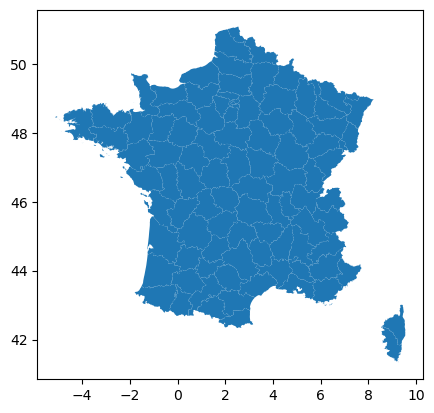

In [20]:
france.plot()

In [21]:
france

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."
...,...,...,...
91,91,Essonne,"POLYGON ((2.22656 48.77610, 2.22866 48.77451, ..."
92,92,Hauts-de-Seine,"POLYGON ((2.29097 48.95097, 2.29162 48.95077, ..."
93,93,Seine-Saint-Denis,"POLYGON ((2.55306 49.00982, 2.55814 49.01201, ..."
94,94,Val-de-Marne,"POLYGON ((2.33190 48.81701, 2.33371 48.81677, ..."


In [22]:
df_carto = pd.merge(left = df_model_cancer, right = france, 
                    how = 'left', left_on='dept', right_on='code')

In [23]:
df_carto.head()

,ind,dept,classe_age,Cancers_ind,code,nom,geometry
0,5588,999,2.0,0,NaN,NaN,None
1,5592,62,2.0,0,62,Pas-de-Calais,"POLYGON ((2.06771 51.00651, 2.06950 51.00606, ..."
2,5593,999,2.0,0,NaN,NaN,None
3,5594,57,2.0,0,57,Moselle,"POLYGON ((7.63529 49.05416, 7.63695 49.05295, ..."
4,5595,44,2.0,0,44,Loire-Atlantique,"MULTIPOLYGON (((-2.62284 47.40975, -2.62341 47..."


In [24]:
df_carto['dept'].unique()

array(['999', '62', '57', '44', '59', '974', '75', '93', '94', '14', '49',
       '86', '38', '83', '91', '92', '67', '30', '69', '13', '77', '95',
       '37', '50', '51', '68', '29', '35', '01', '74', '971', '78', '25',
       '60', '88', '85', '22', '33', '31', '81', '63', '27', '76', '02',
       '80', '17', '40', '12', '66', '26', '03', '42', '07', '84', '972',
       '45', '70', '71', '61', '10', '54', '55', '56', '65', '28', '36',
       '58', '89', '90', '72', '24', '47', '09', '973', '41', '39', '08',
       '53', '64', '79', '11', '34', '43', '19', '82', '73', '06', '2B',
       '21', '16', '23', '15', '04', '32', '976', '87', '46', '05', '2A',
       '18', '52', '48'], dtype=object)

In [25]:
dept_manquants = ['999', '974', '971', '972', '973', '976']

In [26]:
df_carto = df_carto[~df_carto['dept'].isin(dept_manquants)]

In [27]:
df_carto

,ind,dept,classe_age,Cancers_ind,code,nom,geometry
1,5592,62,2.0,0,62,Pas-de-Calais,"POLYGON ((2.06771 51.00651, 2.06950 51.00606, ..."
3,5594,57,2.0,0,57,Moselle,"POLYGON ((7.63529 49.05416, 7.63695 49.05295, ..."
4,5595,44,2.0,0,44,Loire-Atlantique,"MULTIPOLYGON (((-2.62284 47.40975, -2.62341 47..."
8,5636,59,2.0,0,59,Nord,"MULTIPOLYGON (((3.04040 50.15971, 3.04599 50.1..."
14,5667,75,2.0,0,75,Paris,"POLYGON ((2.33190 48.81701, 2.33247 48.81825, ..."
...,...,...,...,...,...,...,...
2048959,4057194,73,NaN,0,73,Savoie,"POLYGON ((6.80252 45.77837, 6.80181 45.77525, ..."
2048961,4057196,13,NaN,0,13,Bouches-du-Rhône,"MULTIPOLYGON (((5.39670 43.17300, 5.39314 43.1..."
2048962,4057197,04,NaN,0,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
2048963,4057198,84,NaN,0,84,Vaucluse,"MULTIPOLYGON (((4.89291 44.36482, 4.89318 44.3..."


In [28]:
cancer_dep = df_carto.groupby('dept')['Cancers_ind'].sum().reset_index()

In [29]:
df_carto = df_carto.merge(cancer_dep, on='dept', suffixes=('', '_sum'))

In [33]:
df_carto = gpd.GeoDataFrame(df_carto, crs='EPSG:4326')

In [31]:
#fig, ax = plt.subplots(figsize=(10, 10))
#df_carto.plot(ax=ax, column='Cancers_ind_sum', legend=True, cmap='OrRd')
#plt.show()

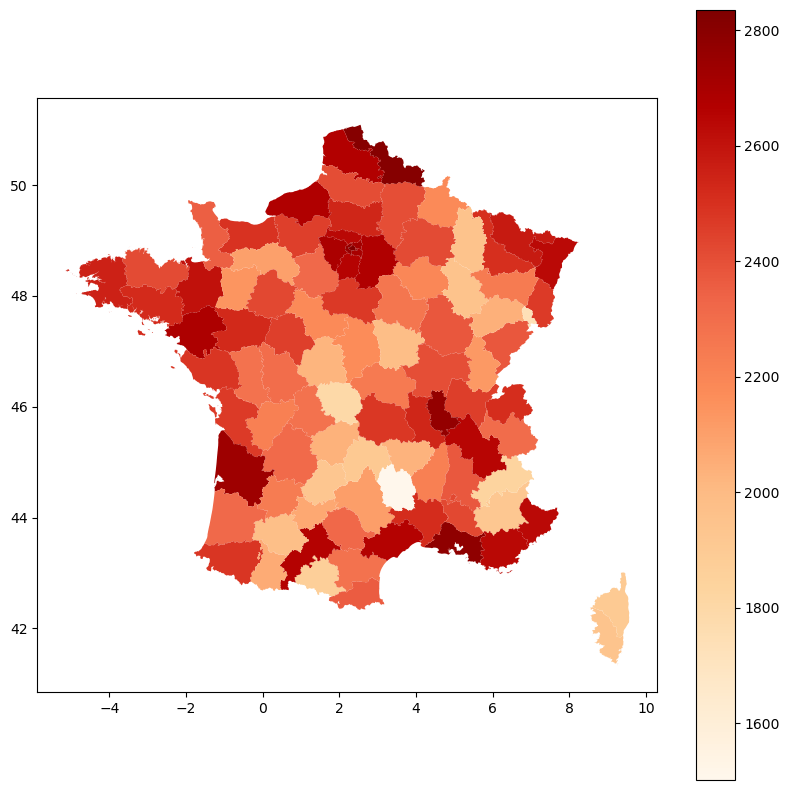

In [40]:
df_carto2 = pd.merge(left = france, right = cancer_dep, 
                    how = 'left', left_on='code', right_on='dept')
fig, ax = plt.subplots(figsize=(10, 10))
df_carto2.plot(ax=ax, column='Cancers_ind', legend=True, cmap='OrRd')
plt.show()

In [39]:
df_carto2

,code,nom,geometry,dept,Cancers_ind
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...",01,2456
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...",02,2403
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ...",03,2250
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...",04,1923
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...",05,1835
...,...,...,...,...,...
91,91,Essonne,"POLYGON ((2.22656 48.77610, 2.22866 48.77451, ...",91,2655
92,92,Hauts-de-Seine,"POLYGON ((2.29097 48.95097, 2.29162 48.95077, ...",92,2753
93,93,Seine-Saint-Denis,"POLYGON ((2.55306 49.00982, 2.55814 49.01201, ...",93,2719
94,94,Val-de-Marne,"POLYGON ((2.33190 48.81701, 2.33371 48.81677, ...",94,2704
